<a href="https://colab.research.google.com/github/yeonghun00/stock-notes/blob/main/analysis/market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- 코스피/코스닥 시총 100순위 변동 
- 1주일/1달 주도주 분석
- 상승률 변동 (20, 60, 120, 250) 
- 강한 테마/이슈 뉴스검색어와 분석으로 연속성 검증
- 조회수순? 영향력 강한 1주일 이내 공시 분석기
- 앞으로 상장할 주식 1주일 치 이슈에 부합하나
- 업황 분석기: 지난 1주 1달치 업황 상승률/ 거래대금 순위

In [1]:
!pip install exchange_calendars

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import requests
from datetime import date
import pandas as pd
from io import StringIO
import exchange_calendars as ecals

XKRX = ecals.get_calendar("XKRX") # 한국 코드

In [3]:
market_type = {
    'all':'ALL',
    'kospi':'STK',
    'kosdaq':'KSQ'
}

def get_ranking(market, ranking_type, start_date, end_date):
  gen_url = 'http://data.krx.co.kr/comm/fileDn/GenerateOTP/generate.cmd'
  url = ''
  if ranking_type == 'highest': url = 'dbms/MDC/EASY/ranking/MDCEASY01501'
  elif ranking_type == 'traded': url = 'dbms/MDC/EASY/ranking/MDCEASY01601'
  elif ranking_type == 'marketcap': url = 'dbms/MDC/EASY/ranking/MDCEASY01701'
  data = {
    'locale': 'ko_KR',
    'mktId': market,
    'itmTpCd': '1',
    'itmTpCd2': '1',
    'trdDd': start_date,
    'strtDd': start_date,
    'endDd': end_date,
    'stkprcTpCd': 'Y',
    'share': '1',
    'money': '1',
    'csvxls_isNo': 'false',
    'name': 'fileDown',
    'url': url
  }
  gen_key = requests.post(gen_url, data=data).text
  down_url = 'http://data.krx.co.kr/comm/fileDn/download_csv/download.cmd'
  data = {'code':gen_key}
  r = requests.post(down_url, data=data)
  r.encoding = 'EUC-KR'
  return pd.read_csv(StringIO(r.text))

In [4]:
def get_ranking_df(start='20220613', end='20220712', freq='1D', market='kospi', ranking_type='marketcap'):
  df = pd.DataFrame()
  for d in pd.date_range(start=start, end=end, freq=freq):
    t = pd.DataFrame()
    dt = d
    if XKRX.is_session(dt) == False:
      dt = XKRX.next_open(dt).replace(tzinfo=None)
    t = get_ranking(market_type[market], ranking_type, dt.strftime('%Y%m%d'), dt.strftime('%Y%m%d'))[['순위', '종목명']]
    t['date'] = dt
    df = df.append(t, ignore_index=True)
  return df

In [5]:
# korean font
!wget 'https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip'
!unzip "NotoSansCJKkr-hinted.zip"
!mv NotoSansCJKkr-Medium.otf /usr/share/fonts/truetype/

--2022-07-14 14:17:44--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 142.251.2.128, 2607:f8b0:4023:c0d::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121163981 (116M) [application/zip]
Saving to: ‘NotoSansCJKkr-hinted.zip.2’

NotoSansCJKkr-hinte 100%[===================>] 115.55M   249MB/s    in 0.5s    

2022-07-14 14:17:45 (249 MB/s) - ‘NotoSansCJKkr-hinted.zip.2’ saved [121163981/121163981]

Archive:  NotoSansCJKkr-hinted.zip
replace LICENSE_OFL.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: LICENSE_OFL.txt         
  inflating: NotoSansCJKkr-Black.otf  
  inflating: NotoSansCJKkr-Bold.otf  
  inflating: NotoSansCJKkr-DemiLight.otf  
  inflating: NotoSansCJKkr-Light.otf  
  inflating: NotoSansCJKkr-Medium.otf  
  inf

In [6]:
from matplotlib import font_manager, rc
font_fname = '/usr/share/fonts/truetype/NotoSansCJKkr-Medium.otf'
font_manager.fontManager.addfont(font_fname)
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)
font_manager._rebuild()

In [7]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedFormatter, FixedLocator

def plot_bump(df='', n_top_ranked=10, title='Title'):
  top_sources = df[df["date"] == df["date"].max()].nsmallest(n_top_ranked, "순위")

  fig, ax = plt.subplots(figsize=(16, 8), subplot_kw=dict(ylim=(0.5, 0.5 + n_top_ranked)))
  #ax.xaxis.set_major_locator(MultipleLocator(1))
  ax.yaxis.set_major_locator(MultipleLocator(1))

  yax2 = ax.secondary_yaxis("right")
  yax2.yaxis.set_major_locator(FixedLocator(top_sources["순위"].to_list()))
  yax2.yaxis.set_major_formatter(FixedFormatter(top_sources["종목명"].to_list()))

  for i, j in df.groupby("종목명"):
      ax.plot("date", "순위", "o-", linewidth=3, markersize=7, data=j, mfc="w")

  ax.invert_yaxis()
  ax.set(xlabel="Date", ylabel="Rank", title=title)
  plt.tight_layout()

In [8]:
from dateutil import relativedelta

t = date.today().strftime("%Y%m%d")
today = t if XKRX.is_session(t) else XKRX.previous_open(t)
w = (date.today() - relativedelta.relativedelta(weeks=1)).strftime("%Y%m%d")
previous_week = w if XKRX.is_session(w) else XKRX.next_open(w)
m = (date.today() - relativedelta.relativedelta(months=1)).strftime("%Y%m%d")
previous_month = m if XKRX.is_session(m) else XKRX.next_open(m)
y = (date.today() - relativedelta.relativedelta(years=1)).strftime("%Y%m%d")
previous_year = y if XKRX.is_session(y) else XKRX.next_open(y)

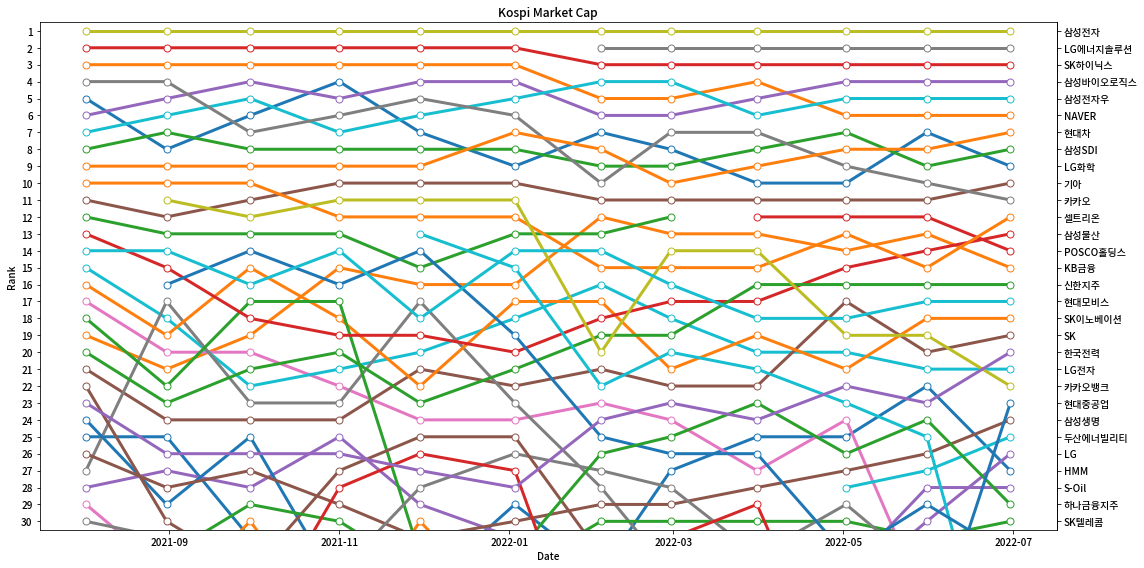

In [9]:
kospi_marketcap_ranking_df = get_ranking_df(previous_year, today, freq='1M', market='kospi', ranking_type='marketcap')
plot_bump(kospi_marketcap_ranking_df, 30, "Kospi Market Cap")

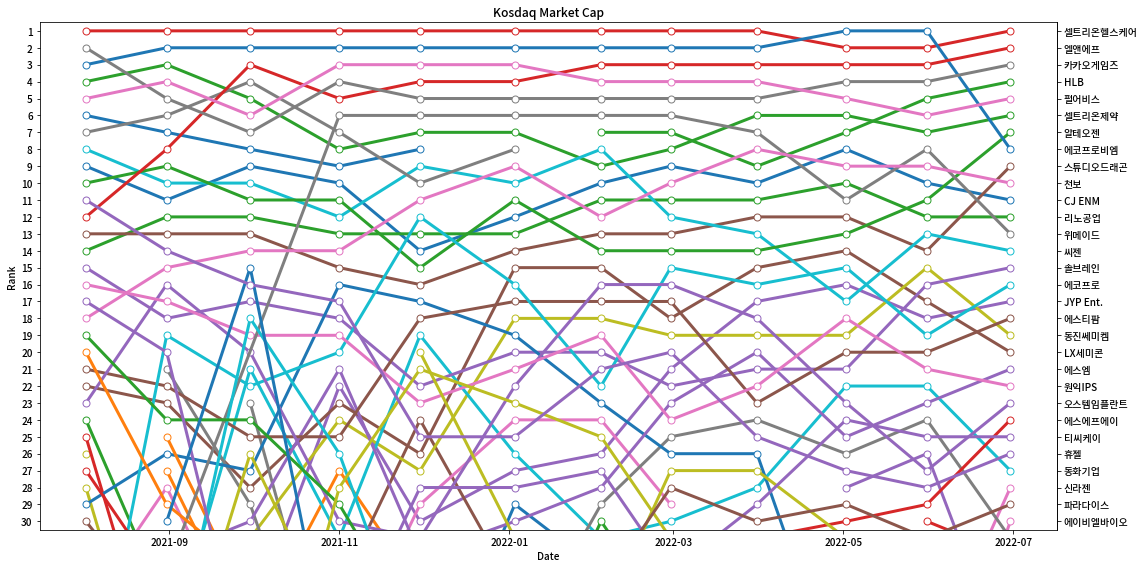

In [10]:
kosdaq_marketcap_ranking_df = get_ranking_df(previous_year, today, freq='1M', market='kosdaq', ranking_type='marketcap')
plot_bump(kosdaq_marketcap_ranking_df, 30, "Kosdaq Market Cap")

Annual King

In [11]:
get_ranking(market_type['kospi'], 'traded', previous_year, today).sort_values('등락률', ascending=False).head(10)

,순위,종목코드,종목명,시장구분,시작일기준가,종료일종가,대비,등락률,거래량_합계,거래량_일평균,거래대금_합계,거래대금_일평균
26,27,11700,한신기계,KOSPI,3060,8780,5720,186.93,2281781633,9237982,15846193047280,64154627722
10,11,249420,일동제약,KOSPI,15900,41600,25700,161.64,740673353,2998678,33655101956650,136255473509
43,44,5070,코스모신소재,KOSPI,32500,51200,18700,57.54,246475195,997875,11596712424550,46950252731
15,16,11070,LG이노텍,KOSPI,223000,339500,116500,52.24,85160453,344779,26685106716227,108036869296
23,24,93370,후성,KOSPI,12100,16500,4400,36.36,893703445,3618233,17753280572150,71875629847
36,37,52690,한전기술,KOSPI,53400,65300,11900,22.28,169404414,685848,13137749905600,53189270873
41,42,10060,OCI,KOSPI,114500,117500,3000,2.62,96815805,391967,11671606857800,47253469060
28,29,17670,SK텔레콤,KOSPI,56161,54900,-1261,-2.25,159818412,647038,15035925941273,60874194094
3,4,302440,SK바이오사이언스,KOSPI,154500,150000,-4500,-2.91,236704080,958316,53732396862300,217540068268
25,26,207940,삼성바이오로직스,KOSPI,854876,825000,-29876,-3.49,18594336,75281,16175612877269,65488311244


In [12]:
get_ranking(market_type['kosdaq'], 'traded', previous_year, today).sort_values('등락률', ascending=False).head(10)

,순위,종목코드,종목명,시장구분,시작일기준가,종료일종가,대비,등락률,거래량_합계,거래량_일평균,거래대금_합계,거래대금_일평균
30,31,5860,한일사료,KOSDAQ,2320,6440,4120,177.59,1637422270,6629240,10784995297350,43663948572
22,23,90710,휴림로봇,KOSDAQ,1150,2745,1595,138.70,5555980435,22493848,13221695631846,53529132113
34,35,258830,세종메디칼,KOSDAQ,2010,4770,2760,137.31,1597041271,6465754,9760600782990,39516602360
38,39,278650,노터스,KOSDAQ,3103,7290,4187,134.93,570291649,2308873,9043077583360,36611650135
19,20,53050,지에스이,KOSDAQ,2135,4705,2570,120.37,2954681637,11962274,14120572993012,57168311713
1,2,112040,위메이드,KOSDAQ,28138,61700,33562,119.28,326475638,1321764,40498243553872,163960500218
2,3,247540,에코프로비엠,KOSDAQ,57101,117000,59899,104.90,100080562,405184,36501266626119,147778407393
0,1,66970,엘앤에프,KOSDAQ,111000,213000,102000,91.89,213978379,866309,40591452534102,164337864511
25,26,307750,국전약품,KOSDAQ,4760,8990,4230,88.87,1120983212,4538394,12432951663865,50335836696
36,37,222800,심텍,KOSDAQ,23300,37550,14250,61.16,228022839,923169,9138676604850,36998690708


Montly King

In [13]:
get_ranking(market_type['kospi'], 'traded', previous_month, today).sort_values('등락률', ascending=False).head(10)

,순위,종목코드,종목명,시장구분,시작일기준가,종료일종가,대비,등락률,거래량_합계,거래량_일평균,거래대금_합계,거래대금_일평균
4,5,302440,SK바이오사이언스,KOSPI,113000,150000,37000,32.74,29485606,1281983,3743519070800,162761698730
13,14,68270,셀트리온,KOSPI,158500,189000,30500,19.24,12342552,536633,2139346703024,93015074045
18,19,249420,일동제약,KOSPI,36250,41600,5350,14.76,51530873,2240473,1827836192300,79471138796
31,32,51900,LG생활건강,KOSPI,665000,720000,55000,8.27,1898717,82553,1268899478922,55169542562
27,28,207940,삼성바이오로직스,KOSPI,786000,825000,39000,4.96,1638449,71237,1330160829815,57833079557
2,3,5380,현대차,KOSPI,175000,182500,7500,4.29,21278663,925159,3770697941196,163943388748
36,37,1470,삼부토건,KOSPI,1955,2000,45,2.30,496804142,21600180,1132710429820,49248279557
25,26,5070,코스모신소재,KOSPI,50400,51200,800,1.59,27848264,1210794,1471934715350,63997161537
41,42,12330,현대모비스,KOSPI,210000,211500,1500,0.71,5049943,219563,1021444791882,44410643125
44,45,17670,SK텔레콤,KOSPI,54700,54900,200,0.37,18491851,803994,985407959914,42843824344


In [14]:
get_ranking(market_type['kosdaq'], 'traded', previous_month, today).sort_values('등락률', ascending=False).head(10)

,순위,종목코드,종목명,시장구분,시작일기준가,종료일종가,대비,등락률,거래량_합계,거래량_일평균,거래대금_합계,거래대금_일평균
46,47,257720,실리콘투,KOSDAQ,2350,5290,2940,125.11,29805214,1295879,675209655700,29356941552
10,11,366030,공구우먼,KOSDAQ,10211,19150,8939,87.54,30085898,1308083,1779405233550,77365444937
15,16,44060,조광ILI,KOSDAQ,1480,2775,1295,87.50,111815323,4861536,1446560758575,62893946025
7,8,205470,휴마시스,KOSDAQ,12750,21850,9100,71.37,120363884,5233212,2147726854250,93379428446
37,38,376180,피코그램,KOSDAQ,21000,35300,14300,68.10,23282779,1012295,774239654400,33662593670
6,7,388050,지투파워,KOSDAQ,22700,36150,13450,59.25,65179549,2833893,2306177887750,100268603815
26,27,56700,신화인터텍,KOSDAQ,2800,4440,1640,58.57,247199285,10747795,957757201285,41641617447
8,9,16790,카나리아바이오,KOSDAQ,27050,42400,15350,56.75,49090101,2134352,1922391676800,83582246817
36,37,84650,랩지노믹스,KOSDAQ,6280,9180,2900,46.18,99808392,4339495,778897267570,33865098590
3,4,214610,미코바이오메드,KOSDAQ,9310,13450,4140,44.47,182894198,7951922,2621614749520,113983249979


Weekly King

In [15]:
get_ranking(market_type['kospi'], 'traded', previous_week, today).sort_values('등락률', ascending=False).head(10)

,순위,종목코드,종목명,시장구분,시작일기준가,종료일종가,대비,등락률,거래량_합계,거래량_일평균,거래대금_합계,거래대금_일평균
31,32,230,일동홀딩스,KOSPI,19750,29800,10050,50.89,9586534,1597756,268352277700,44725379617
3,4,249420,일동제약,KOSPI,28750,41600,12850,44.70,27993646,4665608,1049875566150,174979261025
20,21,11000,진원생명과학,KOSPI,10400,14850,4450,42.79,25860253,4310042,346883500150,57813916692
1,2,302440,SK바이오사이언스,KOSPI,121500,150000,28500,23.46,14902939,2483823,2129026123000,354837687167
46,47,1250,GS글로벌,KOSPI,3050,3380,330,10.82,53431130,8905188,183993525750,30665587625
16,17,137310,에스디바이오센서,KOSPI,43300,47900,4600,10.62,8746071,1457679,414682057950,69113676325
41,42,5070,코스모신소재,KOSPI,46350,51200,4850,10.46,3992293,665382,197086849800,32847808300
25,26,12330,현대모비스,KOSPI,192500,211500,19000,9.87,1525615,254269,312561716500,52093619417
34,35,352820,하이브,KOSPI,149500,163500,14000,9.36,1602919,267153,257408132000,42901355333
8,9,373220,LG에너지솔루션,KOSPI,370500,399500,29000,7.83,1710842,285140,669994576500,111665762750


In [16]:
get_ranking(market_type['kosdaq'], 'traded', previous_week, today).sort_values('등락률', ascending=False).head(10)

,순위,종목코드,종목명,시장구분,시작일기준가,종료일종가,대비,등락률,거래량_합계,거래량_일평균,거래대금_합계,거래대금_일평균
4,5,256840,한국비엔씨,KOSDAQ,7810,12250,4440,56.85,63066784,10511131,722674554820,120445759137
3,4,64550,바이오니아,KOSDAQ,25450,36600,11150,43.81,19551809,3258635,753171869150,125528644858
26,27,241840,에이스토리,KOSDAQ,22800,32600,9800,42.98,9382234,1563706,289395771500,48232628583
11,12,388720,유일로보틱스,KOSDAQ,15450,21900,6450,41.75,19893301,3315550,433420895100,72236815850
42,43,38070,서린바이오,KOSDAQ,12200,17150,4950,40.57,11571817,1928636,187843263150,31307210525
0,1,16790,카나리아바이오,KOSDAQ,30800,42400,11600,37.66,25480216,4246703,1052637216250,175439536042
30,31,32300,한국파마,KOSDAQ,24350,33500,9150,37.58,7617970,1269662,253647634800,42274605800
23,24,337450,SK5호스팩,KOSDAQ,2985,4080,1095,36.68,68093338,11348890,339559685285,56593280881
10,11,950130,엑세스바이오,KOSDAQ,16200,21500,5300,32.72,24035749,4005958,475628053400,79271342233
45,46,94480,갤럭시아머니트리,KOSDAQ,5800,7610,1810,31.21,22208412,3701402,167591679060,27931946510
